## Bayesian model of behaviour ##

This notebook contains all the code (classes and utility functions) to reproduce the reasoning conducted in the paper's section 'Bayesian model of behaviour' 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
from scipy.integrate import quad
from scipy.optimize import minimize

The matlab function te=fbls computes given (ts,tm,wm) the posterior mean via continuous approximation ( see it better in the code and write it down here). Constants are set to c= 0.5846 m= -0.1026 --> is p(posterior mean te | tm)


It will be structured as a main class (that contains the functions used by both models) and subclasses that then over-write and specify the two points in which the model differ (specifically the standard deviation during production and the mean std)

In [ ]:
class BaseBayesianTimingModel:
    """
    Base class for Bayesian models, implements functions that are in common for the two models. 
    Implements:
    - f_bls : Bayesian least-squares estimator, t_e = E[ts | tm]
    - p_tm_given_ts : likelihood p(tm | ts, wm)
    - p_tp_given_te : likelihood p(tp | te, wp) of the path integration process
    - p_tp_given_ts : marginal p(tp | ts, wm, wp) = ∫ p(tp|te) p(tm|ts) dtm
    - neg_log_likelihood
    - fit (MLE) and simulate
    """
    def __init__(self, c= 0.5846, m= -0.1026, tm_lower= 0.0, tm_upper_factor= 2.0):
        """
        c, m: parameters of non uniform prior over ts: prior(ts) ∝ c + m*ts
        tm_lower: lower integration bound for tm
        tm_upper_factor: tm upper bound = tm_upper_factor * max(ts)
        """
        self.c = c
        self.m = m
        self.tm_lower = tm_lower
        self.tm_upper_factor = tm_upper_factor

    def meas_sd(self,ts,wm):
        """
        Measurement SD σ_m(ts) for given wm and ts.
        In different models this is wm * sqrt(ts) or wm * ts, will be overwritten
        tm given ts part, that is first internal representation tm given ts. 
        """
        raise NotImplementedError
    
    def prod_sd(self,te,wp):
        """
        Production SD σ_p(te) for given wp and te.
        In different models this is wp * sqrt(te) or wp * te.
        tp given te part, produced vector given bayesian estimate
        """
        raise NotImplementedError 
    
    def p_tm_given_ts(self,tm,ts,wm):
        """
        Mirrors Matlab Ptmts: p(tm | ts, wm) as a Gaussian centered at ts
        with SD = meas_sd(ts, wm). 
        ts,tm can be scalar or array.
        """
        ts = np.asarray(ts, dtype=float)
        tm = np.asarray(tm, dtype=float)
        sigma = self.meas_sd(ts,wm)
        var= sigma **2
        norm = 1.0 / np.sqrt(2.0*np.pi*var)
        return norm*np.exp(-0.5*(tm-ts)**2/var)
    
    def p_tp_given_te(self,tp,te,wp):
        """
        Mirrors Matlab Ptpte: p(tp | te, wp), path integration, as Gaussian centered at te
        with SD = prod_sd(te, wp).
        tp,te can be both scalars or 1D numpy arrays.
        """
        te = np.asarray(te, dtype=float)
        tp = np.asarray(tp, dtype=float)
        sigma = self.prod_sd(te,wp)
        var= sigma ** 2
        norm = 1.0 /np.sqrt(2.0*np.pi*var)
        return norm * np.exp(-0.5*(tp-te)**2/var)
    
    # Bayesian estimator 

    def f_bls(self, tm,wm,ts_min,ts_max,n_grid = 200):
        """
        Compute BLS estimate te for given tm (can be array) and wm.
        Uses discrete approximation to the integrals over ts.
        tm: scalar or 1D array
        wm: scalar
        ts_min, ts_max: support of true intervals (same as in Matlab: min(ts), max(ts))
        """
        tm = np.atleast_1d(tm).astype(float)
        ts_grid = np.linspace(ts_min, ts_max, n_grid)
        dt = ts_grid[1] - ts_grid[0]


       # Prior(ts) ∝ c + m * ts
        prior = self.c + self.m * ts_grid
       # avoid negative/ zero  prior
        prior = np.maximum(prior, 1e-9)

        te_vals = np.empty_like(tm, dtype=float)

        for i, tm_i in enumerate(tm):
            lik_ts = self.p_tm_given_ts(tm=tm_i, ts=ts_grid, wm=wm)
            weight = prior * lik_ts

            numer = np.sum(weight * ts_grid) * dt
            denom = np.sum(weight) * dt

            if denom <= 1e-15 or not np.isfinite(denom):
            # Fallback: if posterior is numerically degenerate, approximate
            # te by tm 
                te_vals[i] = tm_i 
            else:
                te_vals[i] = numer / denom
 
        # return scalar if input was scalar 
        if te_vals.size == 1:
            return te_vals[0]
        return te_vals

    #Marginal likelihood p(tp | ts, wm, wp)
    def p_tp_given_ts(self,tp,ts,wm,wp,ts_min,ts_max):
        """
        Compute p(tp | ts, wm, wp) by integrating over tm:
            ∫ p(tp | te(tm)) p(tm | ts) dtm

        tp, ts are scalars here (called once per trial in NLL).
        Computation is done from ts, computing implicitely te using the other previously defined functions. 
        """
        lower = self.tm_lower
        upper = self.tm_upper_factor * ts_max

        def integrand(tm_scalar):
            te = self.f_bls(tm=tm_scalar, wm=wm,
                            ts_min=ts_min, ts_max=ts_max)
            val = self.p_tp_given_te(tp=tp, te=te, wp=wp) * \
                    self.p_tm_given_ts(tm=tm_scalar, ts=ts, wm=wm)
            # replace NaN/inf with 0 to keep quad working 
            return np.nan_to_num(val, nan=0.0, posinf=0.0, neginf=0.0)
        
        val, _ = quad(integrand, lower, upper,
                      epsabs=1e-5, epsrel=1e-4, limit = 100)
        
        return val
    
    # Negative log likelihood (not yet finding the minimum)
    def neg_log_likelihood(self, params, ts, tp):
        """
        params: [wm, wp, offset]
        ts, tp: 1D arrays of same length
        """
        wm, wp, offset = params

        # Penalize invalid parameters
        if wm <= 0 or wp <= 0:
            return 1e6

        ts = np.asarray(ts, dtype=float)
        tp = np.asarray(tp, dtype=float)
        ts_min, ts_max = ts.min(), ts.max()

        ll = 0.0
        for ts_i, tp_i in zip(ts, tp):
            p = self.p_tp_given_ts(tp=tp_i - offset,
                                   ts=ts_i,
                                   wm=wm,
                                   wp=wp,
                                   ts_min=ts_min,
                                   ts_max=ts_max)
            # avoid log(0)
            if p <= 0.0 or not np.isfinite(p):
                p = 1e-12
            ll += np.log(p)

        return -ll
    
    # Fitting (MLE)
    def fit(self, ts, tp, w_init=(0.5, 0.5, 0.0)):
        """
        Fit parameters [wm, wp, offset] by minimizing negative log-likelihood.
        Mirrors Matlab fminsearch (Nelder–Mead).
        """
        ts = np.asarray(ts, dtype=float)
        tp = np.asarray(tp, dtype=float)

        def obj(params):
            return self.neg_log_likelihood(params, ts, tp)

        res = minimize(obj, x0=np.array(w_init, dtype=float),
                       method="Nelder-Mead")
        return res  # res.x are the MLEs
    
    # Generative part, simulate trials 
    def simulate(self, ts, wm, wp, offset, rng=None):
        """
        Simulate tm, te, tp for given ts and parameters.
        Mirrors the generative branches in the Matlab functions.
        """
        # The number of points simulated will be the same as ts the ground truth data I pass
        
        ts = np.asarray(ts, dtype=float)
        if rng is None:
            rng = np.random.default_rng()

        # Measurement stage
        sigma_m = self.meas_sd(ts, wm)
        tm = rng.normal(loc=ts, scale=sigma_m)

        # Bayesian estimator
        ts_min, ts_max = ts.min(), ts.max()
        te = self.f_bls(tm=tm, wm=wm, ts_min=ts_min, ts_max=ts_max)

        # Production stage
        sigma_p = self.prod_sd(te, wp)
        tp = rng.normal(loc=te, scale=sigma_p) + offset

        return tm, te, tp


The counter model will exhibit scalar reset, so the both measurement and production standard deviation should have a subscalar dependency on t. 

In [3]:
class CounterModel(BaseBayesianTimingModel):
    """
    Reset --> mental navigation, subscalar model:
    - measurement SD: wm * sqrt(ts)
    - production SD:  wp * sqrt(te)
    """

    def meas_sd(self, ts, wm):
        ts = np.asarray(ts)
        return wm * np.sqrt(ts)

    def prod_sd(self, te, wp):
        te = np.asarray(te)
        return wp * np.sqrt(te)


In [4]:
class NonCounterModel(BaseBayesianTimingModel):
    """
    No-reset--> path integration, scalar model:
    - measurement SD: wm * ts
    - production SD:  wp * te
    """

    def meas_sd(self, ts, wm):
        ts = np.asarray(ts)
        return wm * ts

    def prod_sd(self, te, wp):
        te = np.asarray(te)
        return wp * te

## Model validation ##

The following cells implement some checks to check if the model is updating information correctly or not 

In [ ]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["axes.grid"] = True

# Instantiate models
reset_model = CounterModel()
no_reset_model = NonCounterModel()

# True generative parameters (from the paper)
# These are the parameters used by the model who generates the data
wm_true, wp_true, offset_true = 0.15, 0.20, 0.01
true_params = (wm_true, wp_true, offset_true)

# True ts used in the experiment
base_times = np.arange(0.65, 3.25 + 1e-9, 0.65)
ts_true = np.tile(base_times, 100)  
# 500 trials, 5 unique intervals, tile repeats the interval of 5 values 100 times 

rng = np.random.default_rng(0)
# Random number generator 


### Bayesian estimator visualization ###

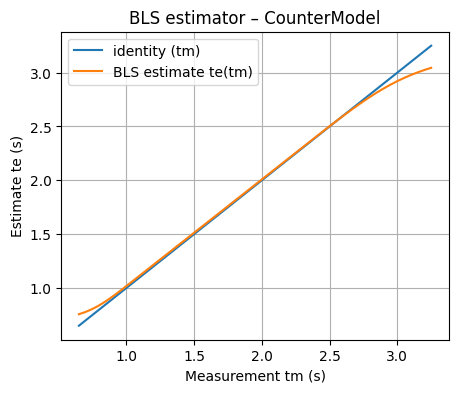

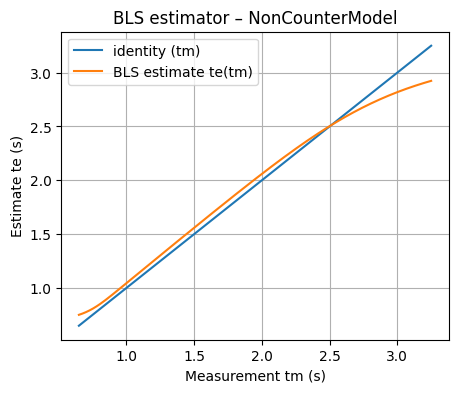

In [ ]:
def plot_f_bls(model, wm, ts_min=0.65, ts_max=3.25, n_points=200, title=""):
    # Generate 200 points equally spaced between minimum and maximum of the intervals 
    tm_grid = np.linspace(ts_min, ts_max, n_points)
    te_grid = model.f_bls(tm_grid, wm=wm, ts_min=ts_min, ts_max=ts_max)
    # Get te estimate using the model 
    
    plt.figure()
    plt.plot(tm_grid, tm_grid, label="Identity (tm)")
    plt.plot(tm_grid, te_grid, label="BLS estimate te(tm)")
    plt.xlabel("Measurement tm (s)")
    plt.ylabel("Estimate te (s)")
    plt.title(title or f"f_bls for {model.__class__.__name__}, wm={wm}")
    plt.legend()
    plt.show()

plot_f_bls(reset_model, wm_true, title="BLS estimator – CounterModel")
plot_f_bls(no_reset_model, wm_true, title="BLS estimator – NonCounterModel")


I plotted the bayesian  estimate of tm. In the counter model noise grows sublinearly so for larger tm the measure is still relatively precise. In the noncounter model noise grows linearly so there is a stronger shrinkage towards the prior. 

### One simulation fitted on the two models ###

In [ ]:
def bias_var_curves(ts, tp):
    ts = np.asarray(ts)
    tp = np.asarray(tp)
    
    means = []
    vars_ = []
    unique_ts = np.unique(ts)
    for t in unique_ts:
        d = tp[ts == t]
        means.append(d.mean())
        vars_.append(d.var(ddof=1))
    means = np.array(means)
    vars_ = np.array(vars_)
    bias = means - unique_ts
    return unique_ts, bias, vars_

# simulate data from "true" model (in this case set to be reset model)
gen_model = reset_model
tm_gen, te_gen, tp_gen = gen_model.simulate(
    ts_true, wm_true, wp_true, offset_true, rng=rng
)

# fit both models to the simulated data
# Simulated data will be stored in tp
def fit_model(model_cls, ts, tp, w_init=(0.5, 0.5, 0.0)):
    model = model_cls()
    res = model.fit(ts, tp, w_init=w_init)
    # in the fitting part identifies the parameters so that the model gets the closest to the true data, tp simulated in this case 
    wm_hat, wp_hat, offset_hat = res.x
    return model, np.array([wm_hat, wp_hat, offset_hat]), res

fit_reset_model, params_reset_hat, res_reset = fit_model(CounterModel, ts_true, tp_gen)
fit_nonc_model, params_nonc_hat, res_nonc = fit_model(NonCounterModel, ts_true, tp_gen)

print("True params:         ", true_params)
print("Fit CounterModel:    ", params_reset_hat)
print("Fit NonCounterModel: ", params_nonc_hat)

True params:          (0.15, 0.2, 0.01)
Fit CounterModel:     [ 0.1302906   0.19416534 -0.01127595]
Fit NonCounterModel:  [0.11197167 0.15868999 0.00533409]


The true underlying model that generated the data is the Counter model (the with reset one). As expected the parameters' estimates from the Counter model are closer to the true values with respect to the estimates of the Non Counter model. This is a sign that the model is working as intended. It could be better but we simulate only 500 data points, probably increasing the number of simulations would improve how close the estimates are. 

### Posterior predictive check ###

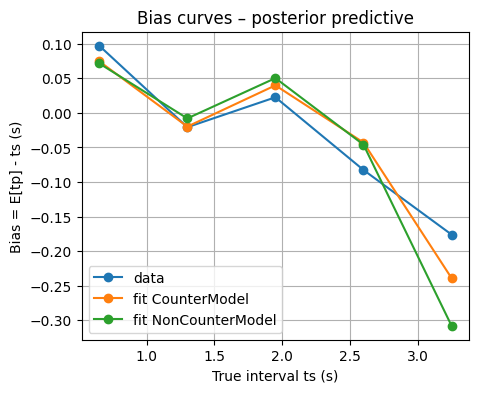

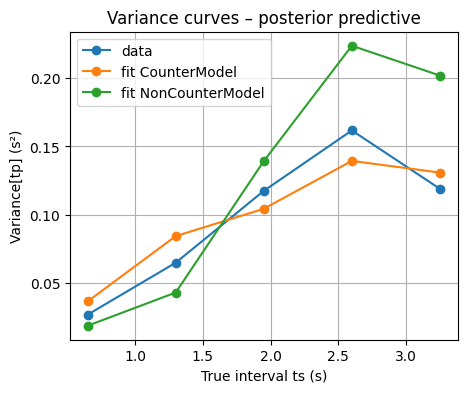

In [ ]:
# generate model predicted tp, posterior predictive distribution 
def posterior_predictive(model, params, ts, n_rep=1, rng=None):
    wm_hat, wp_hat, offset_hat = params
    if rng is None:
        rng = np.random.default_rng()
    # one simulated dataset with same ts
    _, _, tp_sim = model.simulate(ts, wm_hat, wp_hat, offset_hat, rng=rng)
    return tp_sim

# bias/variance for “data”
ts_u, bias_data, var_data = bias_var_curves(ts_true, tp_gen) # tp_gen previously generated by reset model 

# bias/variance for each fitted model
# I make the two models simulate other data, ideally the data simulated from the reset model would be closer to the syntetic data than the other 
# (since they both are simulated from same model)
tp_sim_reset = posterior_predictive(fit_reset_model, params_reset_hat, ts_true, rng=rng)
tp_sim_nonc  = posterior_predictive(fit_nonc_model,  params_nonc_hat,  ts_true, rng=rng)

_, bias_reset, var_reset = bias_var_curves(ts_true, tp_sim_reset)
_, bias_nonc,  var_nonc  = bias_var_curves(ts_true, tp_sim_nonc)

# plots 
plt.figure()
plt.plot(ts_u, bias_data, "o-", label="data")
plt.plot(ts_u, bias_reset, "o-", label="fit CounterModel")
plt.plot(ts_u, bias_nonc,  "o-", label="fit NonCounterModel")
plt.xlabel("True interval ts (s)")
plt.ylabel("Bias = E[tp] - ts (s)")
plt.title("Bias curves – posterior predictive")
plt.legend()
plt.show()

plt.figure()
plt.plot(ts_u, var_data, "o-", label="data")
plt.plot(ts_u, var_reset, "o-", label="fit CounterModel")
plt.plot(ts_u, var_nonc,  "o-", label="fit NonCounterModel")
plt.xlabel("True interval ts (s)")
plt.ylabel("Variance[tp] (s²)")
plt.title("Variance curves – posterior predictive")
plt.legend()
plt.show()


The data (blue) lines in the figures are the bias and variance of the original simulated dataset generated from ground truth model, the fit CounterModel (orange) lines are bias and variance of data simulated using the estimated parameters from the CounterModel fit, the fit NonCounterModel (green) lines are the bias and variance of data simulated using the estimated parameters from the NonCounterModel fit. The idea is that the model should be able to generate data that looks like the data it was trained on. In both graphs the orange line (which is the model that was used to generate sinthetic data) follows much closer the true behavioural pattern of the data. 

### Check normalization of p( tp | ts ) ### 

In [10]:
def check_normalization(model, wm, wp, ts_values, ts_min, ts_max):
    for ts_val in ts_values:
        f = lambda tp: model.p_tp_given_ts(tp=tp, ts=ts_val,
                                           wm=wm, wp=wp,
                                           ts_min=ts_min, ts_max=ts_max)
        val, err = quad(f, -10, 10)
        print(f"ts={ts_val:.2f}  integral≈{val:.4f} (err={err:.1e})")

ts_min, ts_max = ts_true.min(), ts_true.max()
check_normalization(reset_model, wm_true, wp_true,
                    ts_values=[0.65, 1.3, 2.6, 3.25],
                    ts_min=ts_min, ts_max=ts_max)


ts=0.65  integral≈1.0000 (err=7.3e-09)
ts=1.30  integral≈1.0000 (err=2.1e-09)
ts=2.60  integral≈1.0000 (err=3.8e-10)
ts=3.25  integral≈1.0000 (err=1.7e-09)


Tests whether the integral on tp is close to 1 for different values of ts.

## IDENTIFYABILITY TEST ###
First I will recreate the identifiability test. To test if models are identifyable I will first generate syntetic data for model A, use this data to fit to model A and B and compute the MSE. For the models to be identifyiable we expect the MSE to be much lower in the correct model that generated the data compared to the other one. I will then repeat the procedure for model B.  


To compare how well the two Bayesian models fit the data we use BIC = Bayesian Information Criterion, a model selection metric used to compare how well two statistical models fit the same dataset while penalizing model complexity. The formula is given by $$ BIC= k* ln(N) + 2*neglogik$$ where k is the number of fitted parameters, N number of data points and negloglike the negative log likelihood of the best fit parameters . 
I will store all the evaluation metrics that Matlab stores like MSE, neglohlike BIC and the recovered parameters. 
The MSE specifically is not the general one but is a formulation only for bias and variance (so it is implemented specifically in the following function)

In [5]:
reset_model= CounterModel()
no_reset_model = NonCounterModel()

# Initialize true ts and parameters 
base_times = np.arange(0.65,3.25 + 1e-9, 0.65)
ts_true= np.tile(base_times,100) # As in the Matlab code, repeat the array in the same fixed order
wm_true, wp_true, offset_true = 0.15, 0.20, 0.01 # Setting parameters the same as matlab code
true_params = (wm_true, wp_true, offset_true)

n_sims= 3 # number of simulations

# Storage: mse_bias_var-like metric, negloglik, bic, and parameter estimates
mse = np.zeros((2, 2, n_sims))         
negloglik = np.zeros((2, 2, n_sims))
bic = np.zeros((2, 2, n_sims))
w_model = np.zeros((2, 2, 3, n_sims))  # 3 params

In [17]:
def mse_bias_var_like(ts, tp_data, tp_model):
    """
    Rough Python analogue of mdl.mse_bias_var:
    sum over unique ts of (bias^2 + var) for data vs model,
    then absolute difference.
    """
    # Ensuring input are vectors 
    ts = np.asarray(ts)
    tp_data = np.asarray(tp_data)
    tp_model = np.asarray(tp_model)

    biases_data = []
    biases_model = []
    vars_data = []
    vars_model = []

    for t in np.unique(ts): # for each unique time 
        mask = (ts == t)
        d = tp_data[mask]
        m = tp_model[mask]
        # compute bias and variance and append it
        biases_data.append(d.mean() - t) 
        biases_model.append(m.mean() - t)
        vars_data.append(d.var(ddof=1))
        vars_model.append(m.var(ddof=1))

    biases_data = np.array(biases_data)
    biases_model = np.array(biases_model)
    vars_data = np.array(vars_data)
    vars_model = np.array(vars_model)
    # Compute summary scores 
    score_data = np.sum(biases_data**2 + vars_data)
    score_model = np.sum(biases_model**2 + vars_model)
    # Return absolute difference 
    return np.abs(score_data - score_model)

In [ ]:

### MODEL IDENTIFYABILITY TEST ### 

# random number generator 
rng = np.random.default_rng(0)

for bb in range(n_sims):
    for modelgen_idx, gen_model in enumerate([reset_model, no_reset_model]):

        #generate synthetic data
        tm_gen, te_gen, tp_gen = gen_model.simulate(
            ts_true, wm_true, wp_true, offset_true, rng=rng
        )

        # fit both models to the same synthetic data
        for modelfit_idx, fit_model_cls in enumerate([CounterModel, NonCounterModel]):
            fit_model = fit_model_cls()
            res = fit_model.fit(ts_true, tp_gen, w_init=(0.5, 0.5, 0.0))
            wm_hat, wp_hat, offset_hat = res.x #ptimized parameters found via MLE 

            # store parameters
            w_model[modelgen_idx, modelfit_idx, :, bb] = res.x

            # compute neg log-likelihood at optimum
            nll = fit_model.neg_log_likelihood(res.x, ts_true, tp_gen)
            negloglik[modelgen_idx, modelfit_idx, bb] = nll

            # BIC: k=3 params, N = number of trials
            N = len(ts_true)
            k = 3
            bic[modelgen_idx, modelfit_idx, bb] = np.log(N) * k + 2 * nll

            # simulate from the fitted model to compute mse_bias_var-like metric
            _, _, tp_fit_gen = fit_model.simulate(
                ts_true, wm_hat, wp_hat, offset_hat, rng=rng
            )
            mse[modelgen_idx, modelfit_idx, bb] = mse_bias_var_like(
                ts_true, tp_gen, tp_fit_gen
            )

            # The MSE metric needs 'true data' (in this case originally generated syntetic data) and simulated data 

KeyboardInterrupt: 